# Problem 2: ICP

In [1]:
import sys
import time
import numpy as np
from tqdm.notebook import tqdm

# You can use other visualization from previous homeworks, like Open3D
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import trimesh
print("Trimesh version:", trimesh.__version__)

Trimesh version: 3.16.2


In [2]:
"""Visualization utilies."""
def show_points(points):
    fig = plt.figure(figsize=(14,8))
    ax = plt.axes(projection ='3d')
    ax.set_xlim3d([-2, 2])
    ax.set_ylim3d([-2, 2])
    ax.set_zlim3d([0, 4])
    ax.scatter(points[:, 0], points[:, 2], points[:, 1])
    

def compare_points(points1, points2, plt_title):
    fig = plt.figure(figsize=(14,8))
    ax = plt.axes(projection ='3d')
    
    ax.set_xlim3d([-2, 2])
    ax.set_ylim3d([-2, 2])
    ax.set_zlim3d([0, 4])
    
    ax.scatter(points1[:, 0], points1[:, 2], points1[:, 1])
    ax.scatter(points2[:, 0], points2[:, 2], points2[:, 1])
    
    ax.set_xlabel('X-axis', fontweight ='bold')
    ax.set_ylabel('Y-axis', fontweight ='bold')
    ax.set_zlabel('Z-axis', fontweight ='bold')
    ax.set_title(plt_title, fontweight ='bold')

### Load source and target point cloud data

In [3]:
"""Load data."""
source_pcd = trimesh.load("../data/banana_source.ply").vertices
target_pcd = trimesh.load("../data/banana_target.ply").vertices
gt_T = np.loadtxt("../data/banana_pose.txt")

assert(source_pcd.shape == target_pcd.shape)
print("Number of 3D points:", source_pcd.shape[0])  # =N

Number of 3D points: 16384


### Function to compute correspondences between source and target pcd using nearest neighbor

In [4]:
def get_correspondence(source_pcd, target_pcd):
    num_pts = source_pcd.shape[0]   # 16384
    correspondences = []
    
    for i in range(num_pts):
        pt = source_pcd[i,:]
        dists = np.linalg.norm(target_pcd - pt, axis=1)  # (16384,)
        
        min_dist_idx = np.argmin(dists)
        correspondences.append((i, min_dist_idx))
    
    correspondences = np.array(correspondences)   # (16384,2)
    return correspondences

In [5]:
start_time = time.time()
correspondences = get_correspondence(source_pcd, target_pcd)  # (16384,2)
print("Time taken to find correspondences:", round(time.time()-start_time, 3), 's')

Time taken to find correspondences: 7.684 s


In [6]:
def compute_cross_covariance(source_pcd, target_pcd, correspondences):
    assert(source_pcd.shape == target_pcd.shape)

    source_corr_pcd = target_pcd[correspondences[:,1], :]
    cov_mat = np.matmul(source_corr_pcd.T, source_pcd)
    
#     cov = np.zeros((3, 3))
#     num_pts = source_pcd.shape[0]

#     for i in range(num_pts):
#         p_point = source_pcd[[i], :]  # (1,3)
#         q_point = target_pcd[[correspondences[i,1]], :]  # (1,3)

#         cov += np.matmul(q_point.T, p_point)
    
#     assert(np.sum(np.abs(cov - cov_mat)) < 1e-10)

    return cov_mat

In [7]:
def verify_rot_mat(R):
    if np.abs(np.linalg.det(R) - 1.0) > 1e-10:
        print("Rotation matrix determinant error!!!:", np.linalg.det(R))
        return False
    
    if np.sum(np.abs(np.matmul(R, R.T) - np.eye(3))) > 1e-5 or np.sum(np.abs(np.matmul(R.T, R) - np.eye(3))) > 1e-5:
        print("Rotation matrix RRT error!!!")
        return False
    
    return True

### Function: ICP Implementation

In [8]:
"""Implement your own ICP."""
def icp(source_pcd, target_pcd, num_itr=10):
    """Iterative closest point.
    
    Args:
        source_pcd (np.ndarray): [N1, 3]
        target_pcd (np.ndarray): [N2, 3]
    
    Returns:
        np.ndarray: [4, 4] rigid transformation to align source to target.
    """
    dists_list = []
    transform = np.eye(4)
    
    target_com = np.mean(target_pcd, axis=0)  # (3,)
    target_pcd_centrd = target_pcd - target_com  # (N,3)

    source_pcd_copy = np.copy(source_pcd)

    for itr in tqdm(range(num_itr)):
        # compute center of mass of the source and target point clouds
        source_com = np.mean(source_pcd_copy, axis=0)  # (3,)
        source_pcd_centrd = source_pcd_copy - source_com  # (N,3)
        
#         correspondences = get_correspondence(source_pcd_copy, target_pcd)
        correspondences = get_correspondence(source_pcd_centrd, target_pcd_centrd)
    
        # compute distance between corresponding points in source and target pcd
        dist = np.sum(np.linalg.norm(source_pcd_copy - target_pcd[correspondences[:,1], :], axis=1))
        dists_list.append(dist)
        
        cov_mat = compute_cross_covariance(source_pcd_centrd, target_pcd_centrd, correspondences)  # (3,3)

        U, S, VT = np.linalg.svd(cov_mat)  # (3,3), (3,3), (3,3)
        R_est = np.matmul(U, VT)   # (3,3)
#         assert(verify_rot_mat(R_est) == True)

        t_est = target_com - np.matmul(R_est, source_com)    # (3,)

        source_pcd_copy = np.matmul(source_pcd_copy, R_est.T) + t_est   # (N,3)

        transform[:3,:3] = np.matmul(R_est, transform[:3,:3])
        transform[:3, 3] = np.matmul(R_est, transform[:3, 3]) + t_est

    return transform, dists_list

### Functions to compute evaluation metrics - RRE and RTE

In [9]:
"""Metric and visualization."""
def compute_rre(R_est: np.ndarray, R_gt: np.ndarray):
    """Compute the relative rotation error (geodesic distance of rotation)."""
    assert R_est.shape == (3, 3), 'R_est: expected shape (3, 3), received shape {}.'.format(R_est.shape)
    assert R_gt.shape == (3, 3), 'R_gt: expected shape (3, 3), received shape {}.'.format(R_gt.shape)
    # relative rotation error (RRE)
    rre = np.arccos(np.clip(0.5 * (np.trace(R_est.T @ R_gt) - 1), -1.0, 1.0))
    return rre


def compute_rte(t_est: np.ndarray, t_gt: np.ndarray):
    assert t_est.shape == (3,), 't_est: expected shape (3,), received shape {}.'.format(t_est.shape)
    assert t_gt.shape == (3,), 't_gt: expected shape (3,), received shape {}.'.format(t_gt.shape)
    # relative translation error (RTE)
    rte = np.linalg.norm(t_est - t_gt)
    return rte

## Visualize source and target pcd before and after ICP transformation

  0%|          | 0/20 [00:00<?, ?it/s]

RRE=0.0, RTE=4.069774370551601e-10


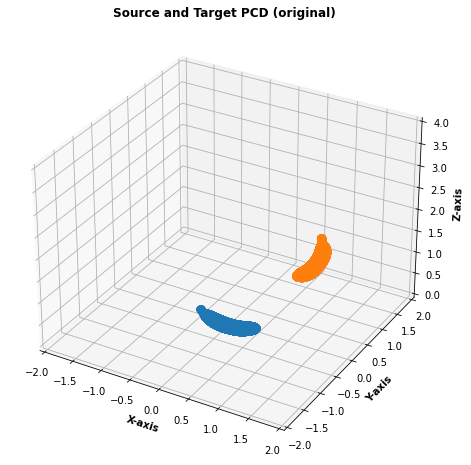

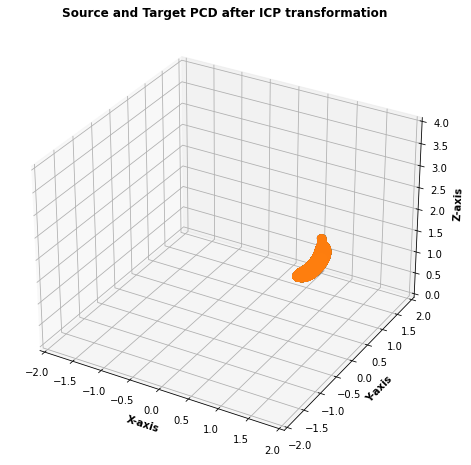

In [10]:
# Visualization
transform_preICP = np.eye(4)
compare_points(source_pcd @ transform_preICP[:3, :3].T + transform_preICP[:3, 3], 
               target_pcd, 
               "Source and Target PCD (original)")

NUM_ICP_ITR = 20
transform_postICP, dists_list = icp(source_pcd, target_pcd, NUM_ICP_ITR)

rre = np.rad2deg(compute_rre(transform_postICP[:3, :3], gt_T[:3, :3]))
rte = compute_rte(transform_postICP[:3, 3], gt_T[:3, 3])
print(f"RRE={rre}, RTE={rte}")

compare_points(source_pcd @ transform_postICP[:3, :3].T + transform_postICP[:3, 3], 
               target_pcd, 
               "Source and Target PCD after ICP transformation")

### RRE = 0.0,      RTE = 4.06977e-10

### Plot showing variation of distance between source and target pcd with ICP iteration

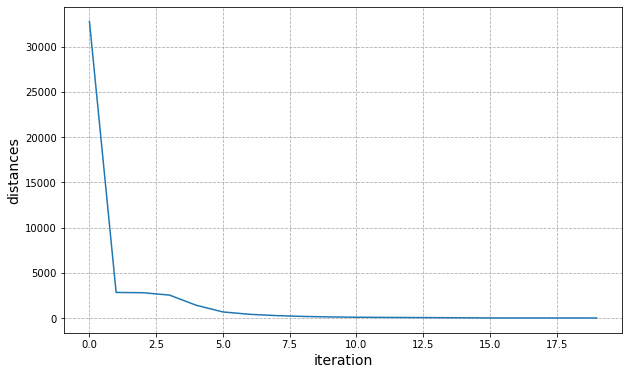

In [11]:
fig = plt.figure(figsize=(10,6))
plt.plot(dists_list)
plt.ylabel("distances", fontsize=14)
plt.xlabel("iteration", fontsize=14)
plt.grid(linestyle='--')

## Problem 4 (Course Feedback)

#### 1. How many hours did you spend on this homework?
- Approximately 75-100 hrs

#### 2. How many hours did you spend on the course each week?
- In general, aside from the assignments, I spend roughly 7-8 hrs on this course/week (including lectures).

#### 3. Do you have any course related feedback?
- No.

## References

- https://nbviewer.org/github/niosus/notebooks/blob/master/icp.ipynb
- http://www.open3d.org/docs/release/tutorial/pipelines/icp_registration.html
- https://towardsdatascience.com/how-to-use-pytorch-as-a-general-optimizer-a91cbf72a7fb
- https://www.youtube.com/watch?v=djnd502836w


## Acknowledgement

I discussed few questions and doubts related to this assignment with following of my classmates. I thank each of them for their valuable time and help.
- Chinmay Talegoankar
- Sambaran Ghosal
- Xuan Tang (piazza post really helpful)